
# Pipeline de Classificação de Texto com Naive Bayes e Bag of Words

Este notebook demonstra um pipeline completo para a classificação de intenções utilizando o algoritmo Naive Bayes com vetorização Bag of Words. O pipeline inclui pré-processamento de texto, treinamento do modelo, avaliação e sugestões de melhorias.

## Sumário
1. [Setup do Ambiente](#setup-do-ambiente)
2. [Carregamento e Visualização dos Dados](#carregamento-e-visualização-dos-dados)
3. [Pré-processamento dos Textos](#pré-processamento-dos-textos)
4. [Definição das Stop Words em Português](#definição-das-stop-words-em-português)
5. [Divisão dos Dados](#divisão-dos-dados)
6. [Treinamento do Modelo](#treinamento-do-modelo)
7. [Testes e Avaliações](#testes-e-avaliações)
8. [Curva ROC](#curva-roc)
9. [Validação Cruzada](#validação-cruzada)
10. [Conclusões e Sugestões de Melhorias](#conclusões-e-sugestões-de-melhorias)

---


## Setup do Ambiente
Este passo configura o ambiente de execução, instalando as bibliotecas necessárias e importando os módulos.

In [36]:
# Instalar bibliotecas necessárias
!pip install scikit-learn matplotlib

# Importar bibliotecas
import pandas as pd
import re
import string
import time
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import tensorflow as tf
import seaborn as sns


In [37]:
# Conectar ao Google Drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Carregamento e Visualização dos Dados
Aqui, carregamos o arquivo de dados e verificamos suas primeiras linhas para entender sua estrutura.

In [38]:
# Carregar o arquivo Excel
PATH = '/content/drive/Shareddrives/Grupo_05/base_aug_20240918_v1.xlsx'
df = pd.read_excel(PATH)

# Visualizar as primeiras linhas do DataFrame para entender a estrutura
df.head()


,Unnamed: 0,Intencao,Texto
0,0,Acesso a conta,Atualizei os site e agora como acessar minha c...
1,1,Acesso a conta,Boa tarde Eu gostaria usar o aplicativo da bra...
2,2,Acesso a conta,Boa tarde Por gentileza alguém pode me ajudar ...
3,3,Acesso a conta,Boa tarde Jessica!Consegui logar minha conta!M...
4,4,Acesso a conta,Boa tarde estou tendo problema com o pin eu nã...


In [39]:
# Filtro de colunas
df = df[['Intencao', 'Texto']]

# Ou, remover linhas com NaNs em 'perguntas_corrigidas' ou 'Intencao'
df = df.dropna(subset=['Intencao', 'Texto'])

## Divisão dos Dados
Dividimos o conjunto de dados em partes de treino e teste para avaliar a performance do modelo.

In [40]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df['Texto'], df['Intencao'], test_size=0.3, random_state=42)


## Vetorização
Dividimos o conjunto de dados em partes de treino e teste para avaliar a performance do modelo.

In [41]:
# Função para vetorizar os dados
def vectorize_data(X_train, ngram_range=(1, 1), stop_words=None):
    vectorizer = CountVectorizer(stop_words=stop_words, ngram_range=ngram_range)
    X_train_vectorized = vectorizer.fit_transform(X_train)
    return X_train_vectorized, vectorizer


In [42]:
# Verificação de tamanhos dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

Tamanho do conjunto de treino: 2411
Tamanho do conjunto de teste: 1034


## Treinamento do Modelo
Treinamos o modelo Naive Bayes usando Bag of Words como técnica de vetorização.

In [43]:
# Função para treinar o modelo
def train_model(X_train_vectorized, y_train, model_type='multinomial'):
    if model_type == 'multinomial':
        model = MultinomialNB()
    elif model_type == 'bernoulli':
        model = BernoulliNB()
    elif model_type == 'gaussian':
        model = GaussianNB()

    start_time = time.time()
    model.fit(X_train_vectorized.toarray() if model_type == 'gaussian' else X_train_vectorized, y_train)
    train_time = time.time() - start_time

    return model, train_time


In [44]:
# Vetorizar os dados
X_train_vectorized, vectorizer = vectorize_data(X_train, ngram_range=(1, 1))

# Treinar o modelo
modelo_treinado, tempo_treinamento = train_model(X_train_vectorized, y_train, model_type='multinomial')

## Testes e Avaliações

Explicação de cada métrica:

Acurácia: Fornece uma visão geral da performance do modelo, indicando o quão bem ele está acertando as previsões em geral.

Recall: Foca em quantos dos verdadeiros positivos foram identificados, importante quando é crucial capturar todos os casos positivos.

Precision: Avalia a qualidade das previsões positivas feitas pelo modelo, relevante quando é necessário evitar falsos positivos.

F1-Score: Oferece uma métrica balanceada que considera tanto a precisão quanto o recall, útil para cenários onde ambos os aspectos são importantes.

In [67]:
# Treinamento do modelo final
model, train_time = train_model(X_train_vectorized, y_train)

# Vetorizar os dados de teste
X_test_vectorized = vectorizer.transform(X_test)

# Previsões no conjunto de teste
y_pred = modelo_treinado.predict(X_test_vectorized)

# Métricas de avaliação
print("\n Avaliação:")
print(classification_report(y_test, y_pred))




 Avaliação:
                                                      precision    recall  f1-score   support

                                      Acesso a conta       0.93      0.93      0.93        44
                            Cadastro de beneficiario       0.75      0.71      0.73        51
                                        Cancelamento       0.90      0.84      0.87        44
                                   Como se inscrever       0.75      0.59      0.66        41
                         Confirmacao de cambio/taxas       0.90      0.87      0.89        86
                  Dificuldades com utilizacao do App       1.00      0.91      0.95        32
                Pedido de envio via metodo "ByPhone"       0.83      0.81      0.82        47
                                Problemas de remessa       0.63      0.91      0.74        54
Problemas/Duvidas de atualizacao de dados cadastrais       0.73      0.75      0.74       183
                    Problemas/Duvidas sobre de

## Curva ROC


A Curva ROC (Receiver Operating Characteristic) é uma representação gráfica que mostra o desempenho de um modelo de classificação binária em diferentes limiares de decisão. O eixo X representa a Taxa de Falsos Positivos (ou seja, a fração de exemplos negativos incorretamente classificados como positivos), enquanto o eixo Y representa a Taxa de Verdadeiros Positivos (a fração de exemplos positivos corretamente classificados). A linha pontilhada cinza indica o desempenho de um classificador aleatório, ou seja, uma classificação sem informação, onde a taxa de verdadeiros positivos seria aproximadamente igual à taxa de falsos positivos. O objetivo é que a curva azul fique o mais próximo possível do canto superior esquerdo, o que indicaria uma alta taxa de verdadeiros positivos com uma baixa taxa de falsos positivos, como ilustrado pela curva apresentada, que mostra um bom desempenho do modelo.




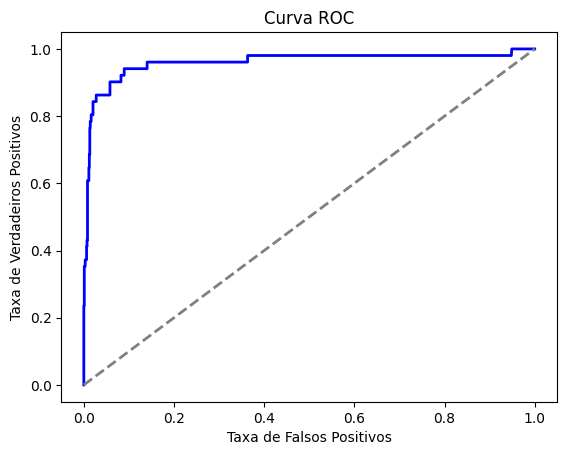

In [52]:
# Curva ROC (exemplo para MultinomialNB)
y_prob = model.predict_proba(X_test_vectorized)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=model.classes_[1])
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.show()


## Validação Cruzada
Aplicamos a técnica de validação cruzada (K-fold) para verificar a robustez do modelo.

Os resultados da validação cruzada mostram as acurácias obtidas em cada uma das cinco dobras de teste, com os valores variando entre 0.7619 e 0.7739. Isso indica que o modelo tem um desempenho consistente e relativamente estável, com pequenas variações entre as diferentes amostras de treino e teste. A acurácia média está em torno de 0.767, sugerindo que o modelo classifica corretamente aproximadamente 76,7% dos exemplos, mas ainda há espaço para melhorias. A validação cruzada é uma técnica importante para avaliar a capacidade de generalização do modelo, e esses resultados indicam que o modelo é razoavelmente confiável em diferentes divisões dos dados.

In [53]:
# K-fold Cross Validation para verificação de desempenho
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(model, X_train_vectorized, y_train, cv=kf)
print(f"Cross-validation accuracy scores: {cross_val_scores}")


Cross-validation accuracy scores: [0.76190476 0.77385892 0.76348548 0.77385892 0.76970954]


## Matriz de Confusão

A partir da matriz de confusão se evidencia que o modelo está generalizando bem com a base de dados fornecida pelo parceiro, tendo poucos erros de classificação em sua predição como Problemas dúvidas Cadastrais com Problemas dúvidas Depósito



In [ ]:
# Ajustar os arrays para garantir que ambos tenham o mesmo número de amostras
min_length = min(len(y_test), len(y_pred))
y_test = y_test[:min_length]
y_pred = y_pred[:min_length]

# Obter as labels únicas e ordená-las
labels = sorted(list(set(y_test)))

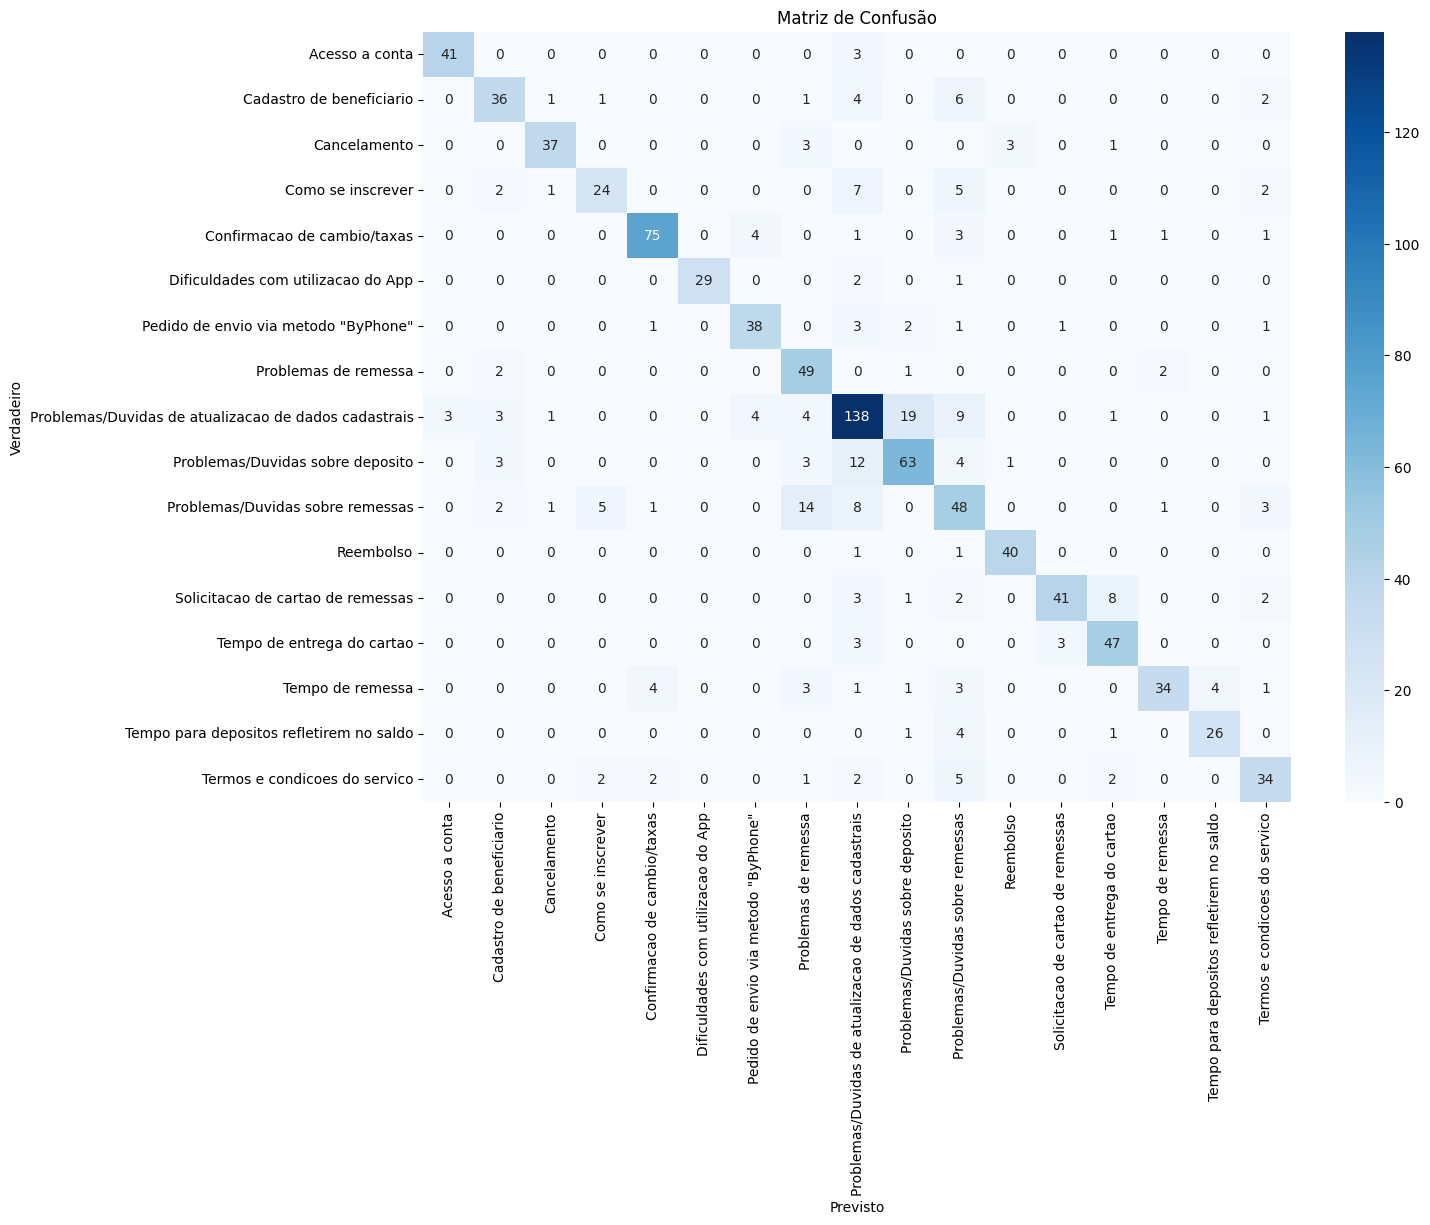

In [55]:
# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()


## Métricas de Classificação por Classe

O gráfico apresenta as métricas de desempenho do modelo de classificação, divididas por intenção. As três métricas exibidas são precisão, recall e f1-score. De modo geral, o modelo apresenta um bom desempenho para a maioria das intenções, com as pontuações variando entre 0,6 e 1,0, dependendo da intenção. Algumas intenções, como "Cancelamento" e "Tempo de entrega do cartão", mostram alta consistência em todas as métricas, enquanto outras, como "Dificuldades com utilização do App", apresentam uma diferença maior entre precisão, recall e f1-score, sugerindo possíveis dificuldades na classificação dessas intenções.








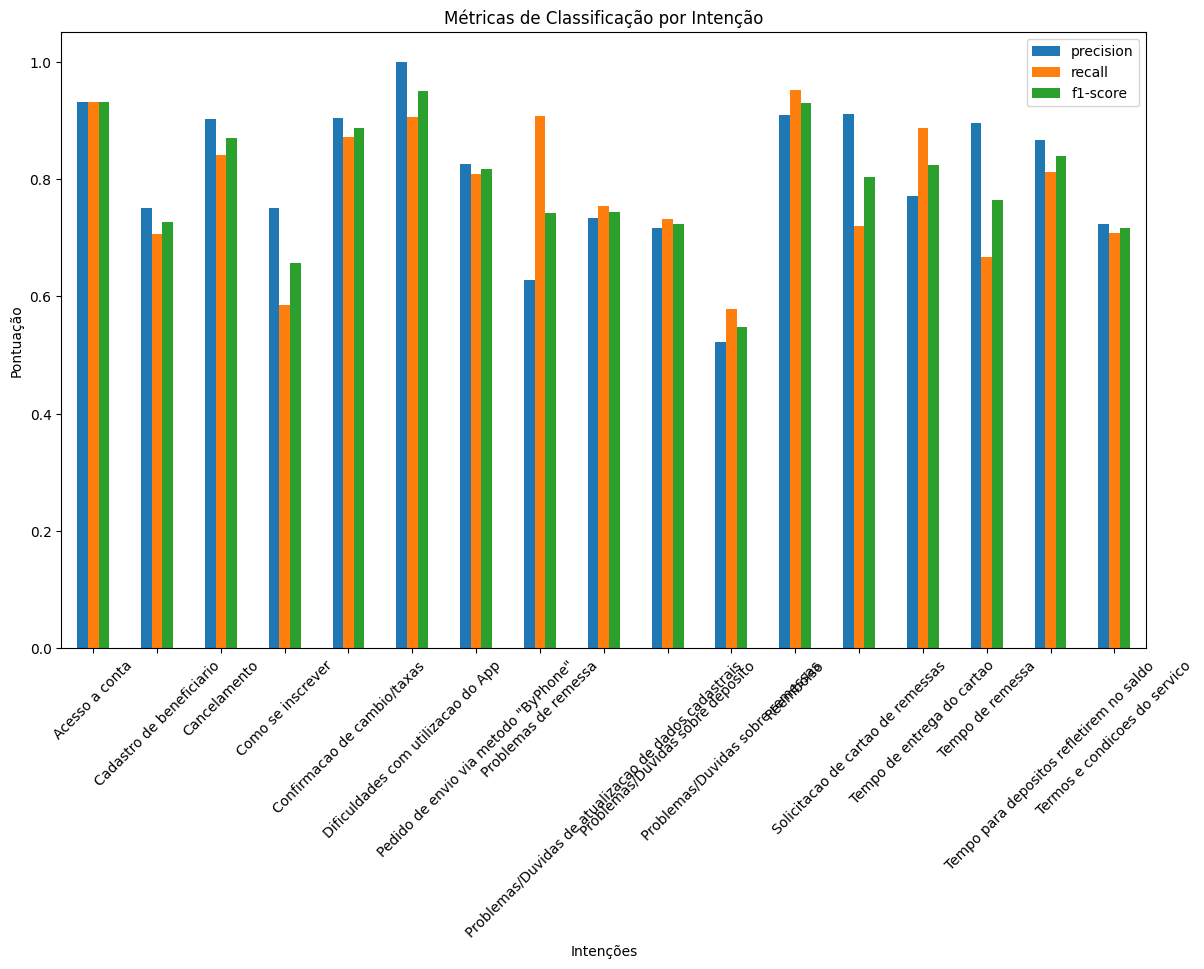

In [56]:
# Gerar o relatório de classificação
report = classification_report(y_test, y_pred, labels=labels, output_dict=True, zero_division=0)
metrics_df = pd.DataFrame(report).transpose().iloc[:-3, :3]  # Ignorar a última linha que não é relevante

# Plotar as métricas
metrics_df.plot(kind='bar', figsize=(14, 8))
plt.title('Métricas de Classificação por Intenção')
plt.ylabel('Pontuação')
plt.xlabel('Intenções')
plt.xticks(rotation=45)
plt.show()

## Performance

Comparação de performance a partir do tempo de treinamento e percebe-se que neste caso a CPU foi mais rápida do que a GPU, isso se dá devido a complexidade do problema. O Bag Of Words é um algoritmo simples que irá apenas contar vetores, fazendo que não seja necessário um alto poder computacional, entretanto isso gera modelos com menor acurácia

In [58]:
# Comparação CPU/GPU (opcional, dependendo do ambiente)
with tf.device('/CPU:0'):
    model_gpu, train_time_cpu = train_model(X_train_vectorized, y_train)


In [63]:
print("Tempo de treinamento com GPU:", train_time, "segundos")
print("Tempo de treinamento com CPU:", train_time_cpu, "segundos")
print("Diferença de tempo CPU vs GPU:", train_time - train_time_cpu, "segundos")

Tempo de treinamento com GPU: 0.020717620849609375 segundos
Tempo de treinamento com CPU: 0.016536235809326172 segundos
Diferença de tempo CPU vs GPU: 0.004181385040283203 segundos
